Routing in LangGraph refers to the ability to conditionally determine which node to execute next based on the current state or the output of the node.. This is implemented using:

-> add_conditional_edges: 

-> State: The arithma's state can store variables that influence routing decisions

-> Condition Functions: Functions that evaluate the state or node output to decide the next step.

# Key concepts:

-> Dynamic Flow: Unlike a linear sequnce, routing let's the graph adapt to intermediate results

-> Condition Logic: You define rules(e.g; "if this, go there; if that, go there")

-> Flexibility: Combines well with parallelization or sequential chains for complex arithmas

In [1]:
import os
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI

load_dotenv()

os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

result = llm.invoke("What is the capital of France?")
result.content

'The capital of France is Paris.'

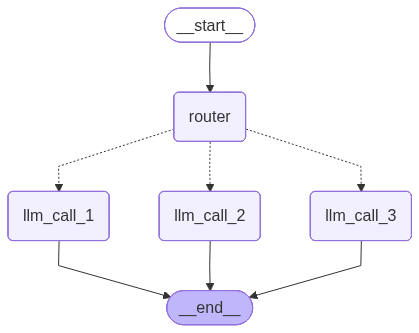

In [8]:
from typing_extensions import Literal, TypedDict
from pydantic import BaseModel, Field
from IPython.display import Image
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import HumanMessage, SystemMessage

# Schema for structured output to use in routing logic
class Route(BaseModel):
    step: Literal["poem", "story", "joke"]=Field(description="The next step to take in the routing process")

## Augment the LLM with schema for structured output
router = llm.with_structured_output(Route)

# State
class State(TypedDict):
    input: str
    decision: str
    output: str

# Define the nodes
def llm_call_1(state: State):
    """write a story"""

    result = llm.invoke(state['input'])
    return {"output": result.content}


def llm_call_2(state: State):
    """write a joke"""
    print("llm call 2 is called")
    result = llm.invoke(state['input'])
    return {"output": result.content}


def llm_call_3(state: State):
    """write a poem"""
    print("llm call 3 is called")
    result = llm.invoke(state['input'])
    return {"output": result.content}

# Define the routing logic
def llm_call_router(state: State):
    """route the input to the appropriate node"""
    decision = router.invoke(
        [
            SystemMessage(content="Route the input to story, joke, or poem based on the users request"),
            HumanMessage(content=state['input'])
        ]
    )
    return {"decision": decision.step}


# Conditional edge function to route to the appropriate node
def route_decision(state: State):
    """ Return the node name you want to visit next"""
    if state['decision'] == "story":
        return "llm_call_1"
    elif state['decision'] == "joke":
        return "llm_call_2"
    elif state['decision'] == "poem":
        return "llm_call_3"

# build the arithma
router_builder = StateGraph(State)
# add the nodes
router_builder.add_node("router", llm_call_router)
router_builder.add_node("llm_call_1", llm_call_1)
router_builder.add_node("llm_call_2", llm_call_2)
router_builder.add_node("llm_call_3", llm_call_3)

# add the edges
router_builder.add_edge(START, "router")
router_builder.add_conditional_edges(
    "router",
    route_decision,
    {
        # name returned by route decision: name of the next node to visit
        "llm_call_1": "llm_call_1",
        "llm_call_2": "llm_call_2",
        "llm_call_3": "llm_call_3",
    }
)
router_builder.add_edge("llm_call_1", END)
router_builder.add_edge("llm_call_2", END)
router_builder.add_edge("llm_call_3", END)

# compile the graph
compiled_graph = router_builder.compile()

# display the graph
display(Image(compiled_graph.get_graph().draw_mermaid_png()))

In [10]:
state = compiled_graph.invoke({"input": "write a story about a cat"})

In [11]:
state['output']

'Once upon a time in a quaint little village nestled between rolling hills, there lived a cat named Whiskers. Whiskers was not just any ordinary cat; he had a coat as soft as clouds and eyes that sparkled like emeralds. He was known throughout the village for his playful spirit and curious nature.\n\nWhiskers lived with an elderly woman named Mrs. Thompson, who had a small cottage filled with the scent of freshly baked bread and the warmth of a crackling fireplace. Every morning, as the sun peeked over the hills, Whiskers would stretch his paws, yawn widely, and embark on his daily adventures.\n\nOne sunny morning, while exploring the garden, Whiskers noticed something unusual. A small, colorful butterfly fluttered just above the flowers, its delicate wings shimmering in the sunlight. Intrigued, Whiskers decided to follow it. The butterfly danced through the air, leading him beyond the garden gate and into the nearby woods.\n\nAs Whiskers ventured deeper into the forest, he marveled at